# Does Giving NFL Quarterbacks Massive Contracts Lead to Higher Passing Production?
### By Matthew Dies

# Overview

### Question
Does giving NFL quarterbacks massive contracts lead to higher passing production? Or will organizations begin to acquire quarterbacks from the draft and "buy in" around their young talent?

### Motivation
As the NFL and its organizations continue to increase revenues, contracts for generational players continue to rise. However, the NFL institutes a salary cap in order to level the playing field among teams that share a different market size (and thus generate varying levels of profit). A strategy some organizations have begun to employ is "buying in", where you acquire a serviceable rookie quarterback and surround him with talent elsewhere on the team. As salaries continue to rise, many people wonder whether giving quarterbacks massive contracts actually generates better performance out of the quarterback. 

### Selection Criteria
When selecting quarterbacks, it is important that the selected quarterback has enough seasons to run an accurate regression on the data. Therefore, each quarterback much have a minimum of 8 years worth of passing statistics (excluding the 2020 NFL season, as the season is currently incomplete). In order to eliminate career backups or commonly injured quarterbacks, a minimum of 2000 career pass attempts for presently retired quarterbacks was established as the second main criterion.

### Databases
The data used in the study was collected from two different sources, one for passing statistics and the other for contract information. The website used to collect data on the quarterbacks' statistics throughout their career is [Pro-Football-Reference](https://www.pro-football-reference.com/), a database that compiles statistics for all NFL players. The website for obtaining payment information for the players was [Over The Cap](https://overthecap.com/). On both sites, the displayed tables were imported to Microsoft Excel and then used in the Pandas dataframes.

# Approach

### Assumptions
The main simplifying assumption for the sake of simplicity is that quarterbacks are only gauged on their passing ability. While this many have been mostly true prior to the 1990s, beginning around then quarterbacks began to run the ball with some success in the NFL. The peak of the dual-threat quarterback began around the 2010s, as strategy from college football began to creep into the professional game. Quarterbacks main purpose is primarily to pass the ball, so this assumption is not far from how NFL organizations analyze their quarterback's worth. This assumption allows us to model a quarterbacks performance based only on their passing ability and how much they were paid.

### Model
The regression will be run in this Jupyter notebook, running a Python program with packages such as Pandas, Statsmodels, and Plot.ly. The model will use data to create an OLS estimate for a quarterback's passer rating based on their passing attempts, completions, touchdowns, interceptions, and total cash paid for each year. The formulas given below show how to calculate passer rating in the NFL.
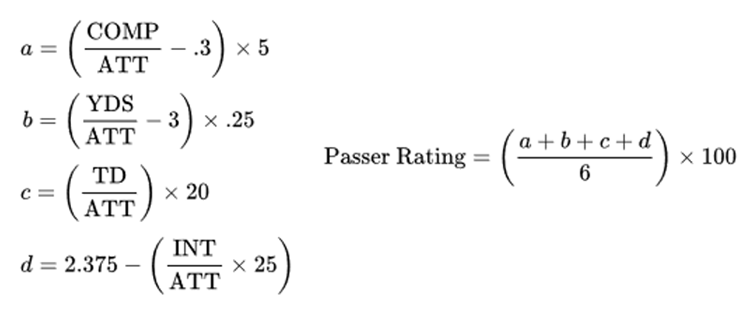

### Visualizations
To visualize the data, Pandas dataframes and Plot.ly will be used to display information about quarterbacks' passing statistics, contract information, and trends.

# Data Collection and Dataframe Creation

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import plotly.express as px

pd.set_option('float_format', '{0}'.format) # forces pandas to display all numbers as full integers

In [46]:
# Creates dataframes for quarterbacks
def create_dataframe(p_file_path):
    p_df = pd.read_excel(p_file_path, index_col = 0) # reads file path and creates df
    slim_p_df = p_df[['Cmp', 'Att', 'Yds', 'TD', 'Int', 
                 'Rate', 'AV']].copy() # fetches relevant columns
    years_list = list(slim_p_df.index.values)
    if (2020 in years_list):
        slim_p_df = slim_p_df.drop([2020]) # drops 2020 year from data
    
    as_list = slim_p_df.index.tolist() # gathers list of indices for dataframe
    for year in as_list: # for each year in index
        index = as_list.index(year) # gathers current index
        if type(year) == str: # if the year is a string
            year = year.replace("+","") # removes +
            year = year.replace("*","") # removes *
            if year.isdecimal(): # if the year is a year
                year = int(year) # converts to integer
        as_list[index] = year # replaces current index with year value
    slim_p_df.index = as_list # replaces indices with recreated indices
    
    indices = as_list[:as_list.index('Career')] # gathers list of indices in shortened df
    drop_list = [n for n in as_list if n not in indices] # gathers list of indices to drop
    slim_p_df = slim_p_df.drop(drop_list) # drops irrelevant indices
    
    s_file_folder = 'C:\\Users\\matth\\Documents\\Dayton\\Semester 7\\MTH 480\\Contracts\\' # folder for contract data
    s_filename = p_filename # filename of QB
    s_file_type = '.xlsx' # file type
    
    s_filepath = s_file_folder + s_filename + s_file_type # creates file path
    
    s_df = pd.read_excel(s_filepath, index_col = 0) # reads file path and creates df
    slim_s_df = s_df[['Base Salary', 'Cash Paid']].copy() # fetches relevant columns
    slim_s_df = slim_s_df.rename(columns={'Base Salary': 'Salary', 'Cash Paid': 'Cash'}) # renames columns
    years_list = list(slim_s_df.index.values)
    if (2020 in years_list):
        slim_s_df = slim_s_df.drop([2020]) # drops 2020 year from data
    slim_s_df = slim_s_df.div(1000000)
    
    frames = [slim_p_df, slim_s_df] # creates list of both modified dataframes
    
    complete_df = pd.concat(frames, axis=1) # merges dataframes on year index column
    
    data_types = complete_df.dtypes.value_counts() # gathers all datatypes
    numerical_count = 0 # initializes count for numerical datapts
    categorical_count = 0 # initializes count for categorical datapts
    for dtype in data_types.index: # for each datapt
        if dtype == 'float64' or dtype == 'int64' or dtype == 'float' or dtype == 'int': # if type is numerical
            numerical_count += data_types[dtype] # increase numerical count
        else: # otherwise
            categorical_count += data_types[dtype] # increase categorical count
    
    indices_list = list(complete_df.index.values) # gathers list of indices
    if ('Total' in indices_list): # if 'Total' exists in the data
        complete_df = complete_df.drop(['Total']) # drops Total data
    complete_df = complete_df.fillna(0) # replaces blank cells with string
    complete_df = complete_df[complete_df['Rate'] != 0]
    df_dict[p_filename] = complete_df # fills df_dict with completed dataframe

In [47]:
p_file_folder = 'C:\\Users\\matth\\Documents\\Dayton\\Semester 7\\MTH 480\\' # folder for player information
p_filenames = ['Aaron_Rodgers', 'Andy_Dalton', 'Ben_Roethlisberger', 'Cam_Newton',
              'Carson_Palmer', 'Chad_Pennington', 'Dan_Marino', 'David_Carr',
              'Derek_Anderson', 'Donovan_McNabb', 'Drew_Bledsoe', 'Drew_Brees',
              'Eli_Manning', 'Jake_Plummer', 'Jason_Campbell', 'Jay_Cutler', 'Joe_Flacco',
              'John_Elway', 'Josh_McCown', 'Kirk_Cousins', 'Kurt_Warner', 'Kyle_Orton',
              'Mark_Brunell', 'Mark_Sanchez', 'Matt_Cassel', 'Matt_Hasselbeck',
              'Matt_Ryan', 'Matt_Schaub', 'Matthew_Stafford', 'Michael_Vick', 'Nick_Foles',
              'Peyton_Manning', 'Philip_Rivers', 'Russell_Wilson', 'Ryan_Fitzpatrick',
              'Sam_Bradford', 'Steve_McNair', 'Steve_Young', 'Tom_Brady',
              'Tony_Romo', 'Troy_Aikman'] # list of all QB's
p_file_type = '.xlsx' # file type
df_dict = {key: None for key in p_filenames} # initializes dict with QB's as keys

for p_filename in p_filenames: # for every player
    p_file = p_file_folder + p_filename + p_file_type # creates file path
    create_dataframe(p_file) # calls function to create dict of QB's and dataframes

In [48]:
# Prints the dataframe for the passed quarterback
def print_dataframe(quarterback):
    qb_name = quarterback.replace('_', ' ') # replaces '_' with space
    print("Career data for {}:".format(qb_name)) # prints string with QB name
    print(df_dict[quarterback]) # prints dataframe

# Dataframe Display
**Note:** The numbers presented below for Salary and Cash are displayed in millions of dollars.

In [57]:
# Main method
print_dataframe('Chad_Pennington') # prints completed dataframe for inputted quarterback

Career data for Chad Pennington:
       Cmp   Att    Yds   TD  Int  Rate   AV  Salary    Cash
2000   2.0   5.0   67.0  1.0  0.0 127.1  0.0   0.193 4.32401
2001  10.0  20.0   92.0  1.0  0.0  79.6  0.0   0.298   0.298
2002 275.0 399.0 3120.0 22.0  6.0 104.2 12.0   0.375 2.34399
2003 189.0 297.0 2139.0 13.0 12.0  82.9  7.0     4.0    5.25
2004 242.0 370.0 2673.0 16.0  9.0  91.0 10.0     1.0    19.0
2005  49.0  83.0  530.0  2.0  3.0  70.9  2.0     1.0     3.0
2006 313.0 485.0 3352.0 17.0 16.0  82.6 12.0   0.585    9.04
2007 179.0 260.0 1765.0 10.0  9.0  86.1  5.0     4.0     4.0
2008 321.0 476.0 3653.0 19.0  7.0  97.4 13.0     3.5    5.75
2009  51.0  74.0  413.0  1.0  2.0  76.0  1.0     3.9    5.75
2010   1.0   2.0   19.0  0.0  0.0  83.3  0.0     2.5     2.7


# Running OLS Regression

In [52]:
# runs regression for all quarterbacks
regr_summary_dict = dict() # initializes dict for regression summaries
regr_estimates_dict = dict() # initializes dict for regression estimates
for p_filename in p_filenames: # for all quarterbacks
    result = sm.ols(formula="Rate ~ Cmp + Att + Yds + TD + Int + Cash",
                    data=df_dict[p_filename]).fit() # fit OLS regression
    regr_summary_dict.update({p_filename: result.summary()}) # update summary dict
    regr_estimates_dict.update({p_filename: result.params}) # update estimates dict

C:\Users\matth\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15

C:\Users\matth\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=9

C:\Users\matth\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16

C:\Users\matth\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=14

C:\Users\matth\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=11

C:\Users\matth\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=17

C:\Users\matth\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 .

In [54]:
# Prints the regression summary for the passed quarterback
def print_regression(quarterback):
    qb_name = quarterback.replace('_', ' ') # replaces '_' with space
    print("Regression summary for {}:".format(qb_name)) # prints string with QB name
    print(regr_summary_dict[quarterback]) # prints dataframe

In [55]:
# Prints the regression estimates for the passed quarterback
def print_estimates(quarterback):
    qb_name = quarterback.replace('_', ' ') # replaces '_' with space
    print("Regression estimates for {}:".format(qb_name)) # prints string with QB name
    print(regr_estimates_dict[quarterback]) # prints dataframe

In [56]:
print_regression('Eli_Manning')

Regression summary for Eli Manning:
                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     12.05
Date:                Wed, 11 Nov 2020   Prob (F-statistic):           0.000738
Time:                        22:47:37   Log-Likelihood:                -42.174
No. Observations:                  16   AIC:                             98.35
Df Residuals:                       9   BIC:                             103.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72

In [77]:
# Displays regression summaries for all quarterbacks
for p_filename in p_filenames:
    print_regression(p_filename)

Regression summary for Aaron Rodgers:
                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     2.029
Date:                Wed, 11 Nov 2020   Prob (F-statistic):              0.174
Time:                        22:47:37   Log-Likelihood:                -60.315
No. Observations:                  15   AIC:                             134.6
Df Residuals:                       8   BIC:                             139.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

                            OLS Regression Results                            
Dep. Variable:                   Rate   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     8.355
Date:                Wed, 11 Nov 2020   Prob (F-statistic):             0.0103
Time:                        22:47:37   Log-Likelihood:                -35.126
No. Observations:                  13   AIC:                             84.25
Df Residuals:                       6   BIC:                             88.21
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     79.0046      5.162     15.306      0.0

In [58]:
print_estimates('Eli_Manning')

Regression estimates for Eli Manning:
Intercept      72.13985386076817
Cmp           0.1718273696489666
Att         -0.14947686909300018
Yds         0.008799195538489558
TD             0.547491904337329
Int          -0.7133668702496474
Cash        0.059327352248454535
dtype: float64


# Visualization

In [59]:
plot_dict = dict()
for p_filename in p_filenames: # for all quarterbacks
    df = px.data.tips()
    fig = px.scatter(df_dict[p_filename], x="Cash", y="Rate", trendline="ols")
    fig.update_traces(
        line=dict(dash="dot", width=2),
        selector=dict(type="scatter", mode="lines"))
    plot_dict.update({p_filename: fig})

In [60]:
# Displays the plot (with trendline) for the passed quarterback
def display_plot(quarterback):
    qb_name = quarterback.replace('_', ' ') # replaces '_' with space
    print("Plot for {}:".format(qb_name)) # prints string with QB name
    plot_dict[quarterback].show() # displays plot

In [63]:
display_plot('John_Elway')

Plot for John Elway:


In [62]:
# Displays all plots for viewing
for p_filename in p_filenames:
    display_plot(p_filename)

Plot for Aaron Rodgers:


Plot for Andy Dalton:


Plot for Ben Roethlisberger:


Plot for Cam Newton:


Plot for Carson Palmer:


Plot for Chad Pennington:


Plot for Dan Marino:


Plot for David Carr:


Plot for Derek Anderson:


Plot for Donovan McNabb:


Plot for Drew Bledsoe:


Plot for Drew Brees:


Plot for Eli Manning:


Plot for Jake Plummer:


Plot for Jason Campbell:


Plot for Jay Cutler:


Plot for Joe Flacco:


Plot for John Elway:


Plot for Josh McCown:


Plot for Kirk Cousins:


Plot for Kurt Warner:


Plot for Kyle Orton:


Plot for Mark Brunell:


Plot for Mark Sanchez:


Plot for Matt Cassel:


Plot for Matt Hasselbeck:


Plot for Matt Ryan:


Plot for Matt Schaub:


Plot for Matthew Stafford:


Plot for Michael Vick:


Plot for Nick Foles:


Plot for Peyton Manning:


Plot for Philip Rivers:


Plot for Russell Wilson:


Plot for Ryan Fitzpatrick:


Plot for Sam Bradford:


Plot for Steve McNair:


Plot for Steve Young:


Plot for Tom Brady:


Plot for Tony Romo:


Plot for Troy Aikman:


# Conclusion

In [76]:
# Analyzes results of regression
pos_est_count = 0
neg_est_count = 0
avg_est = 0
for p_filename in p_filenames:
    cash_estimate = regr_estimates_dict[p_filename]['Cash']
    if cash_estimate > 0:
        pos_est_count += 1
    else:
        neg_est_count += 1
    avg_est += cash_estimate
avg_est = avg_est / len(p_filenames)
print('Positive estimates: ' + str(pos_est_count) + ', Negative estimates: ' + str(neg_est_count) + 
      ', Average Estimate: ' + str(avg_est))

Positive estimates: 22, Negative estimates: 19, Average Estimate: 0.266353691438647


### Analyzing Results: Key Takeaways
Of the 41 quarterbacks where the regression was run, 22 have a positive estimated coefficient for the Cash variable, and 19 are negative. This means that the correlation between cash and a quarterback's passing performance varies between players on average, all else equal. It should be noted that the average coefficient estimate for all quarterbacks is positive, seeing an average increase in passer rating by 1 point for every additional $3.75M paid to the player. The strength of the overall models are semi-strong, but this will be discussed further later.

### Analyzing Results: Coefficient Estimate Explanation
Contracts are granted to NFL players based on consistency and contract renewal. When a quarterback is drafted, they generally are paid close to a certain (minimum) set amount agreed upon by the NFL and the NFL Players Association based on the player's draft location and position. When an organization deems that a quarterback is consistently talented, they will likely seek to extend the player's contract with the team by offering them a new deal. These contracts give the player much more money per year, and are offered with the expectation that the player will continue to perform at a high level. Therefore, the initial renewal of the contract (and subsequent renewals) likely place downward pressure on the coefficient estimates, as **a new contract is not given with the expectation of improvement. It is given with the expecation of continued success.** Quarterbacks who continue to perform efficiently will be offered more and more money but likely will not show any noticeable improvement.

### Analyzing Results: Coefficient Estimate Explanation cont.
Our average coefficient estimate for all quarterbacks in this data set is about 0.2664, meaning the average quarterback has an increase in passer rating of about 0.2664 points for every additional million dollars paid. As previously mentioned, the coefficient estimate for the Cash variable was positive in 22 quarterbacks, and negative  in the remaining 19. All signs point to the facts that these quarterbacks, on average, showed little to no change in their passer rating relative to the amount they were paid during that year. This goes directly with our assumption that contracts are given based upon consistent success and performance, and shows that the average quarterback's contract has generally little effect on their performance.

### Strength of Results
However, we have to analyze the strength of our results before considering ourselves qualified to run an NFL organization. Although the R-squared values of the models are generally strong and generally hover around the range of 0.8 to 0.9 or greater, the p-values for the Cash variable indicate that the results ore often not significant at the 5% (or even 10% level). Therefore, it may be the case that, on average, we fail to reject the null hypothesis that cash has no effect on a quarterback's passer rating. This is what our results indicate anyways, and what the theory behind the estimates supports.

# Issues

### Panel Data Set Complications
Working with panel data is innately a bit more complex than using cross-sectional data, as many variables change annually that cannot be controlled for in a model. For example, a quarterback going from one team to another will have to learn an entirely new playbook, play under different coaches, against different opponents, and with different teammates. A quarterback cannot be realistically expected to perform with perfect consistency under constantly changing conditions from year to year.  

### Data Collection
Filtering and collecting data for the quarterbacks who met the criteria had to be done manually on an individual basis, meaning that data collection was a long and painful process. Additionally, contract information for NFL players was not collected until recent decades, which means that almost all quarterbacks in the dataset are from the mid 1980s or later. So for every quarterback who met the criteria for the study, roughly about one in six of those quarterbacks had the necessary contract information to be included. This meant data collection was a painful process of finding the qualifying quarterbacks, collecting their passing statistics, cross-checking this with the availability of their contract information, and manually reformatting the Excel files to be imported into a database. 

# Future Work

### Further Analysis of Quarterbacks' Talent
For further investigation into this topic, I would consider the all-around success of a quarterback instead of solely the passing statistics. A potential way to do this would be to use [ESPN's QBR](https://www.espn.com/blog/statsinfo/post/_/id/123701/how-is-total-qbr-calculated-we-explain-our-quarterback-rating), a metric that accounts for a quarterback's all-around statline from a game instead of solely passing statistics. This means accounting for running, winning the game, penalties, and "garbage time" statistics, or stats obtained when the game is likely already lost and are meaningless to the outcome of the game. **Essentially, ESPN's QBR is a metric of how much the quarterback increased their team's win probability.** However, this metric is not without its faults. First off, it is a black-box statistic with no released formula, since ESPN does not want to make this stat publicly available. Also, it only became available in the middle of the 2000's decade, so data before the metric became available cannot be used with this statistic.

### Other Potential Research Questions 
Other possible further work could be done by applying a similar regression to other high-paid positions, like running backs. Running backs are often seen as a disposable position due to the physicality of the position and the availability of talent. Therefore, another potential interesting research question would be whether it is worth it for NFL organizations to commit to a running back for a long-term contract or fielding running backs by committee. 

# **Questions?**